In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle as pkl
import tensorflow as tf

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append('..')

import metrics

import warnings
warnings.filterwarnings('once')

In [8]:
train_path = Path('../data/Yearly-train.csv')
test_path = Path('../data/Yearly-test.csv')

In [9]:
train = pd.read_csv(train_path).drop('V1', axis=1)
test = pd.read_csv(test_path).drop('V1', axis=1)

In [10]:
np.seterr(all='ignore')

def get_last_N(series, N=18):
    ser_N = series.dropna().iloc[-N:].values
    if len(ser_N) < N:
        pad = [ser_N[0]] * (N - len(ser_N))
        ser_N = np.r_[pad, ser_N]
    return ser_N

In [11]:
X_test_30 = np.array([get_last_N(ser[1], N=30) for ser in train.iterrows()])
X_test_24 = np.array([get_last_N(ser[1], N=24) for ser in train.iterrows()])
X_test_18 = np.array([get_last_N(ser[1], N=18) for ser in train.iterrows()])
X_test_12 = np.array([get_last_N(ser[1], N=12) for ser in train.iterrows()])

X_all = {12: X_test_12, 18: X_test_18, 24: X_test_24, 30: X_test_30}

y_test = test.values

In [12]:
def get_predictions(model, data):
        
    x = data[..., np.newaxis]
    
    mn, mx = x.min(axis=1), x.max(axis=1)
    x_sc = (x[..., 0] - mn) / (mx - mn)

    pred = model(x_sc[..., np.newaxis])

    return pred[..., 0] * (mx - mn) + mn

In [44]:
def ensemble_preds(model_family, data):

    preds = []
    
    model_dirs = [model_family + '__{}/best_weights.h5'.format(i) for i in range(60)]
    
    for model_dir in tqdm(model_dirs):

        mape = metrics.build_mape(overlap=6)
        smape = metrics.build_smape(overlap=6)
        mase_estimate = metrics.build_mase(overlap=6)
        owa_estimate = metrics.build_owa(overlap=6)
        reconstruction_loss = metrics.build_reconstruction_loss(overlap=6)

        model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                                      'MASE_estimate': mase_estimate,
                                                                      'OWA_estimate': owa_estimate,
                                                                      'reconstruction_loss': reconstruction_loss})
        preds.append(get_predictions(model, data))

        tf.keras.backend.clear_session()

    return np.stack(preds)

In [55]:
for i in inputs:
    for o in range(6, i+7, 2):
        print('inp: {}  out: {}'.format(i, o))
        family = '../results/final/inp_{}__out_{}__aug_0.95__loss_mae__bksize_700__bkact_relu__dir_conv4__ksize_5__opt_adam__lr_0.001'.format(i, o)
        preds = ensemble_preds(family, X_all[i])
        np.save('../predictions/final/inp_{}_out_{}'.format(i, o), preds)


  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 6



100%|██████████| 60/60 [01:18<00:00,  1.30s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 8



100%|██████████| 60/60 [01:31<00:00,  1.53s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 10



100%|██████████| 60/60 [01:57<00:00,  1.96s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 12



100%|██████████| 60/60 [02:24<00:00,  2.41s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 14



100%|██████████| 60/60 [01:28<00:00,  1.48s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 16



100%|██████████| 60/60 [02:10<00:00,  2.17s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 18



100%|██████████| 60/60 [01:54<00:00,  1.91s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 6



100%|██████████| 60/60 [01:39<00:00,  1.66s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 8



100%|██████████| 60/60 [01:53<00:00,  1.88s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 10



100%|██████████| 60/60 [01:35<00:00,  1.59s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 12



100%|██████████| 60/60 [02:15<00:00,  2.26s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 14



100%|██████████| 60/60 [01:26<00:00,  1.44s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 16



100%|██████████| 60/60 [01:55<00:00,  1.92s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 18



100%|██████████| 60/60 [02:09<00:00,  2.15s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 20



100%|██████████| 60/60 [01:46<00:00,  1.77s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 22



100%|██████████| 60/60 [02:04<00:00,  2.08s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 24



100%|██████████| 60/60 [01:37<00:00,  1.62s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 6



100%|██████████| 60/60 [01:14<00:00,  1.24s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 8



100%|██████████| 60/60 [01:23<00:00,  1.39s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 10



100%|██████████| 60/60 [01:24<00:00,  1.41s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 12



100%|██████████| 60/60 [01:25<00:00,  1.42s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 14



100%|██████████| 60/60 [01:30<00:00,  1.51s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 16



100%|██████████| 60/60 [01:31<00:00,  1.53s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 18



100%|██████████| 60/60 [01:31<00:00,  1.53s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 20



100%|██████████| 60/60 [01:29<00:00,  1.49s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 22



100%|██████████| 60/60 [01:36<00:00,  1.61s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 24



100%|██████████| 60/60 [01:31<00:00,  1.53s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 26



100%|██████████| 60/60 [01:37<00:00,  1.63s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 28



100%|██████████| 60/60 [02:04<00:00,  2.08s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 30



100%|██████████| 60/60 [01:34<00:00,  1.58s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 6



100%|██████████| 60/60 [01:14<00:00,  1.25s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 8



100%|██████████| 60/60 [01:23<00:00,  1.39s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 10



100%|██████████| 60/60 [01:29<00:00,  1.49s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 12



100%|██████████| 60/60 [01:29<00:00,  1.48s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 14



100%|██████████| 60/60 [01:30<00:00,  1.50s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 16



100%|██████████| 60/60 [01:31<00:00,  1.52s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 18



100%|██████████| 60/60 [01:38<00:00,  1.64s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 20



100%|██████████| 60/60 [01:36<00:00,  1.61s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 22



100%|██████████| 60/60 [01:37<00:00,  1.62s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 24



100%|██████████| 60/60 [01:38<00:00,  1.63s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 26



100%|██████████| 60/60 [01:34<00:00,  1.58s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 28



100%|██████████| 60/60 [01:41<00:00,  1.69s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 30



100%|██████████| 60/60 [01:38<00:00,  1.64s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 32



100%|██████████| 60/60 [01:45<00:00,  1.76s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 34



100%|██████████| 60/60 [01:40<00:00,  1.67s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 36



100%|██████████| 60/60 [01:40<00:00,  1.68s/it]


In [171]:
def evaluate_ensemble(preds, y_test):
    ensemble_preds = np.median(preds, axis=0)[:, 6:]
    return np.nanmean(metrics.SMAPE(y_test, ensemble_preds))

In [129]:
preds_12 = ensemble_preds(models_dirs_12, X_test_12)
preds_18 = ensemble_preds(models_dirs_18, X_test_18)
preds_24 = ensemble_preds(models_dirs_24, X_test_24)
preds_30 = ensemble_preds(models_dirs_30, X_test_30)

100%|██████████| 10/10 [00:54<00:00,  5.42s/it]


In [172]:
print('12:', evaluate_ensemble(preds_12, y_test))
print('18:', evaluate_ensemble(preds_18, y_test))
print('24:', evaluate_ensemble(preds_24, y_test))
print('30:', evaluate_ensemble(preds_30, y_test))

12: 13.261511095018664
18: 13.076728663033528
24: 13.11537587949124
30: 13.190604202735628


In [173]:
preds_all = np.vstack([preds_12, preds_18, preds_24, preds_30])

## Check different combinations of ensembles

In [174]:
print('12-18:', evaluate_ensemble(preds_all[:20], y_test))
print('18-24:', evaluate_ensemble(preds_all[10:30], y_test))
print('24-30:', evaluate_ensemble(preds_all[20:], y_test))
print('12-24:', evaluate_ensemble(preds_all[list(range(10)) + list(range(20,30))], y_test))
print('18-30:', evaluate_ensemble(preds_all[list(range(10,20)) + list(range(30,40))], y_test))
print('12-30:', evaluate_ensemble(preds_all[list(range(10)) + list(range(30, 40))], y_test))

12-18: 13.13453129069502
18-24: 13.056790909029205
24-30: 13.102335959721822
12-24: 13.085778845235502
18-30: 13.031021052865956
12-30: 13.050785984672558


In [175]:
print('12-18-24:', evaluate_ensemble(preds_all[:30], y_test))
print('18-24-30:', evaluate_ensemble(preds_all[10:], y_test))
print('12-18-30:', evaluate_ensemble(preds_all[list(range(20)) + list(range(30,40))], y_test))
print('12-24-30:', evaluate_ensemble(preds_all[list(range(10)) + list(range(20,40))], y_test))

12-18-24: 13.0616180936804
18-24-30: 13.058598954164925
12-18-30: 13.04128980371711
12-24-30: 13.06748919063401


In [177]:
print('12-18-24-30:', evaluate_ensemble(preds_all, y_test))

12-18-24-30: 13.04152083900084


In [213]:
results = {}
results['12'] = evaluate_ensemble(preds_12, y_test)
results['18'] = evaluate_ensemble(preds_18, y_test)
results['24'] = evaluate_ensemble(preds_24, y_test)
results['30'] = evaluate_ensemble(preds_30, y_test)
results['12-18'] = evaluate_ensemble(preds_all[:20], y_test)
results['18-24'] = evaluate_ensemble(preds_all[10:30], y_test)
results['24-30'] = evaluate_ensemble(preds_all[20:], y_test)
results['12-24'] =  evaluate_ensemble(preds_all[list(range(10)) + list(range(20,30))], y_test)
results['18-30'] = evaluate_ensemble(preds_all[list(range(10,20)) + list(range(30,40))], y_test)
results['12-30'] = evaluate_ensemble(preds_all[list(range(10)) + list(range(30, 40))], y_test)
results['12-18-24'] = evaluate_ensemble(preds_all[:30], y_test)
results['18-24-30'] = evaluate_ensemble(preds_all[10:], y_test)
results['12-18-30'] = evaluate_ensemble(preds_all[list(range(20)) + list(range(30,40))], y_test)
results['12-24-30'] = evaluate_ensemble(preds_all[list(range(10)) + list(range(20,40))], y_test)
results['12-18-24-30'] = evaluate_ensemble(preds_all, y_test)

(12.9, 13.3)

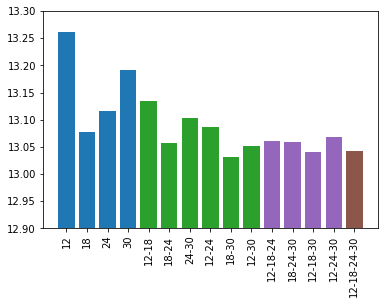

In [214]:
plt.bar(results.keys(), results.values(), color=['C0'] * 4 + ['C2'] * 6 + ['C4'] * 4 + ['C5'])
plt.xticks(rotation=90)
plt.ylim([12.9, 13.3])

In [221]:
for k, v in results.items():
    print('{:>11} : {:.5f}'.format(k, v))

         12 : 13.26151
         18 : 13.07673
         24 : 13.11538
         30 : 13.19060
      12-18 : 13.13453
      18-24 : 13.05679
      24-30 : 13.10234
      12-24 : 13.08578
      18-30 : 13.03102
      12-30 : 13.05079
   12-18-24 : 13.06162
   18-24-30 : 13.05860
   12-18-30 : 13.04129
   12-24-30 : 13.06749
12-18-24-30 : 13.04152


## Same-sized ensembles

In [183]:
random_12 = list(np.random.choice(10, size=5, replace=False))
random_18 = list(np.random.choice(10, size=5, replace=False) + 10)
random_24 = list(np.random.choice(10, size=5, replace=False) + 20)
random_30 = list(np.random.choice(10, size=5, replace=False) + 30)

In [184]:
print('12-18:', evaluate_ensemble(preds_all[random_12 + random_18], y_test))
print('18-24:', evaluate_ensemble(preds_all[random_18 + random_24], y_test))
print('24-30:', evaluate_ensemble(preds_all[random_24 + random_30], y_test))
print('12-24:', evaluate_ensemble(preds_all[random_12 + random_24], y_test))
print('18-30:', evaluate_ensemble(preds_all[random_18 + random_30], y_test))
print('12-30:', evaluate_ensemble(preds_all[random_12 + random_30], y_test))

12-18: 13.177941828776355
18-24: 13.072728939357345
24-30: 13.128982542554313
12-24: 13.093431344072037
18-30: 13.065927407740764
12-30: 13.053725054903657


In [185]:
random_12 = list(np.random.choice(10, size=3, replace=False))
random_18 = list(np.random.choice(10, size=3, replace=False) + 10)
random_24 = list(np.random.choice(10, size=3, replace=False) + 20)
random_30 = list(np.random.choice(10, size=3, replace=False) + 30)

In [186]:
print('12-18-24:', evaluate_ensemble(preds_all[random_12 + random_18 + random_24], y_test))
print('18-24-30:', evaluate_ensemble(preds_all[random_18 + random_24 + random_30], y_test))
print('12-18-30:', evaluate_ensemble(preds_all[random_12 + random_18 + random_30], y_test))
print('12-24-30:', evaluate_ensemble(preds_all[random_12 + random_24 + random_30], y_test))

12-18-24: 13.076021568594838
18-24-30: 13.06914004411142
12-18-30: 13.04199381545786
12-24-30: 13.064863600363244


In [187]:
random_12 = list(np.random.choice(10, size=2, replace=False))
random_18 = list(np.random.choice(10, size=3, replace=False) + 10)
random_24 = list(np.random.choice(10, size=3, replace=False) + 20)
random_30 = list(np.random.choice(10, size=2, replace=False) + 30)

In [188]:
print('12-18-24-30:', evaluate_ensemble(preds_all[random_12 + 
                                                  random_18 + 
                                                  random_24 + 
                                                  random_30], y_test))

12-18-24-30: 13.052416366020834


In [215]:
results2 = {}
results2['12'] = evaluate_ensemble(preds_12, y_test)
results2['18'] = evaluate_ensemble(preds_18, y_test)
results2['24'] = evaluate_ensemble(preds_24, y_test)
results2['30'] = evaluate_ensemble(preds_30, y_test)
results2['12-18'] = evaluate_ensemble(preds_all[random_12 + random_18], y_test)
results2['18-24'] = evaluate_ensemble(preds_all[10:30], y_test)
results2['24-30'] = evaluate_ensemble(preds_all[20:], y_test)
results2['12-24'] = evaluate_ensemble(preds_all[list(range(10)) + list(range(20,30))], y_test)
results2['18-30'] = evaluate_ensemble(preds_all[list(range(10,20)) + list(range(30,40))], y_test)
results2['12-30'] = evaluate_ensemble(preds_all[list(range(10)) + list(range(30, 40))], y_test)
results2['12-18-24'] =  evaluate_ensemble(preds_all[random_12 + random_18 + random_24], y_test)
results2['18-24-30'] = evaluate_ensemble(preds_all[random_18 + random_24 + random_30], y_test)
results2['12-18-30'] = evaluate_ensemble(preds_all[random_12 + random_18 + random_30], y_test)
results2['12-24-30'] = evaluate_ensemble(preds_all[random_12 + random_24 + random_30], y_test)
results2['12-18-24-30'] = evaluate_ensemble(preds_all[random_12 + random_18 + random_24 + random_30], y_test)

(12.9, 13.3)

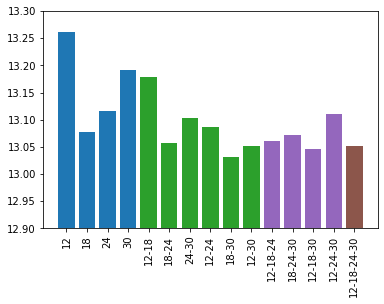

In [217]:
plt.bar(results2.keys(), results2.values(), color=['C0'] * 4 + ['C2'] * 6 + ['C4'] * 4 + ['C5'])
plt.xticks(rotation=90)
plt.ylim([12.9, 13.3])

In [222]:
for k, v in results.items():
    print('{:>11} : {:.5f}'.format(k, v))

         12 : 13.26151
         18 : 13.07673
         24 : 13.11538
         30 : 13.19060
      12-18 : 13.13453
      18-24 : 13.05679
      24-30 : 13.10234
      12-24 : 13.08578
      18-30 : 13.03102
      12-30 : 13.05079
   12-18-24 : 13.06162
   18-24-30 : 13.05860
   12-18-30 : 13.04129
   12-24-30 : 13.06749
12-18-24-30 : 13.04152
